In [1]:
%matplotlib inline
import torch
import torch.nn as nn
from torch.nn import functional as F
from torch import optim
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.animation
import math, random
torch.__version__

'1.10.0+cpu'

# 3.3 通过Sin预测Cos
在介绍循环神经网络时候我们说过，循环神经网络由于其的特殊结构，十分十分擅长处理时间相关的数据，下面我们就来通过输入sin函数，输出cos函数来实际使用。
首先，我们还是定义一些超参数

In [2]:
TIME_STEP = 10 # rnn 时序步长数
INPUT_SIZE = 1 # rnn 的输入维度
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu") 
H_SIZE = 64 # of rnn 隐藏单元个数
EPOCHS=300 # 总共训练次数
h_state = None # 隐藏层状态

由于是使用sin和cos函数，所以这里不需要dataloader，我们直接使用Numpy生成数据，Pytorch没有π这个常量，所以所有操作都是用Numpy完成

In [3]:
steps = np.linspace(0, np.pi*2, 256, dtype=np.float32)
x_np = np.sin(steps) 
y_np = np.cos(steps)

生成完后，我们可视化一下数据

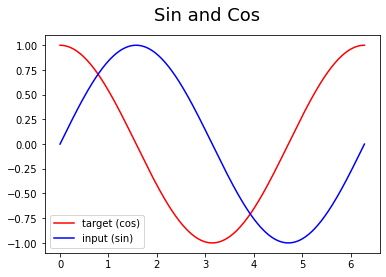

In [4]:
plt.figure(1)
plt.suptitle('Sin and Cos',fontsize='18')
plt.plot(steps, y_np, 'r-', label='target (cos)')
plt.plot(steps, x_np, 'b-', label='input (sin)')
plt.legend(loc='best')
plt.show()

下面定义一下我们的网络结构

In [5]:
class RNN(nn.Module):
    def __init__(self):
        super(RNN, self).__init__()
        self.rnn = nn.RNN(
        input_size=INPUT_SIZE,
        hidden_size=H_SIZE, 
        num_layers=1, 
        batch_first=True,
        )
        self.out = nn.Linear(H_SIZE, 1)
    def forward(self, x, h_state):
         # x (batch, time_step, input_size)
         # h_state (n_layers, batch, hidden_size)
         # r_out (batch, time_step, hidden_size)
        r_out, h_state = self.rnn(x, h_state)
        outs = [] # 保存所有的预测值
        for time_step in range(r_out.size(1)): # 计算每一步长的预测值
            outs.append(self.out(r_out[:, time_step, :]))
        return torch.stack(outs, dim=1), h_state
         # 也可使用以下这样的返回值
         # r_out = r_out.view(-1, 32)
         # outs = self.out(r_out)
         # return outs, h_state

下面我们定义我们的网络

In [6]:
rnn = RNN().to(DEVICE)
optimizer = torch.optim.Adam(rnn.parameters()) # Adam优化，几乎不用调参
criterion = nn.MSELoss() # 因为最终的结果是一个数值，所以损失函数用均方误差

由于没有测试集，所以我们训练和测试写在一起了

EPOCHS: 19,Loss:0.054180


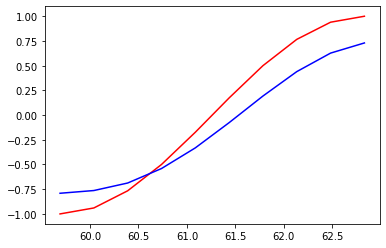

EPOCHS: 39,Loss:0.019160


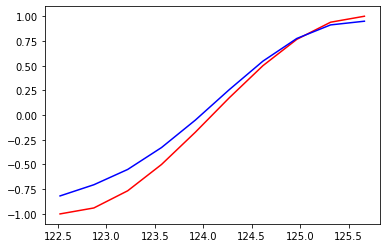

EPOCHS: 59,Loss:0.001353


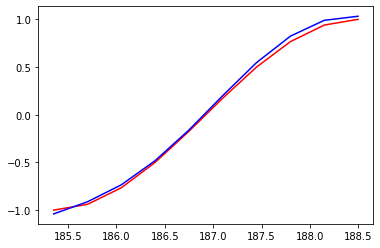

EPOCHS: 79,Loss:0.000496


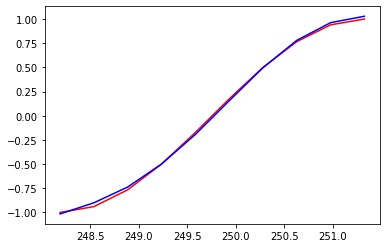

EPOCHS: 99,Loss:0.001199


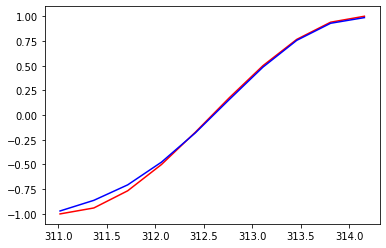

EPOCHS: 119,Loss:0.001210


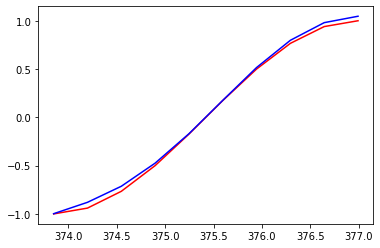

EPOCHS: 139,Loss:0.001800


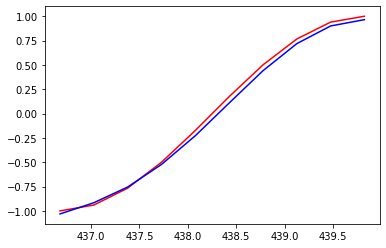

EPOCHS: 159,Loss:0.009915


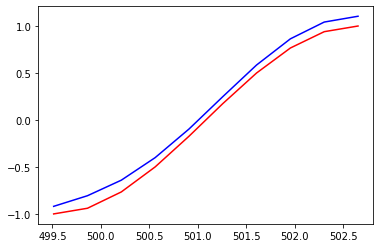

EPOCHS: 179,Loss:0.003069


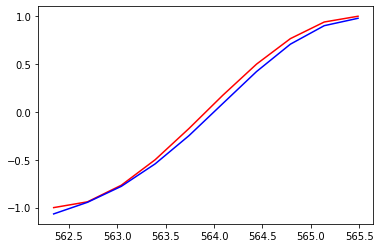

EPOCHS: 199,Loss:0.002322


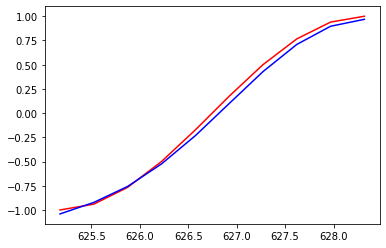

EPOCHS: 219,Loss:0.004945


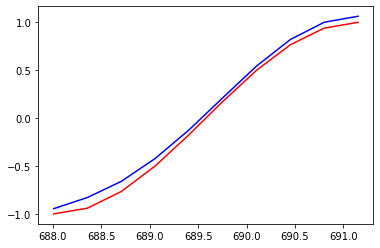

EPOCHS: 239,Loss:0.010813


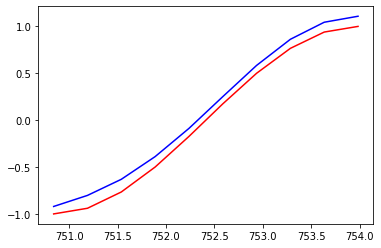

EPOCHS: 259,Loss:0.008630


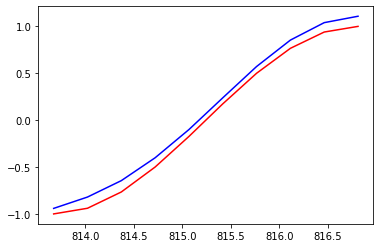

EPOCHS: 279,Loss:0.007687


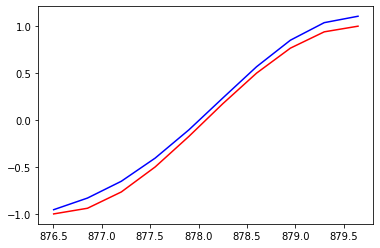

EPOCHS: 299,Loss:0.006893


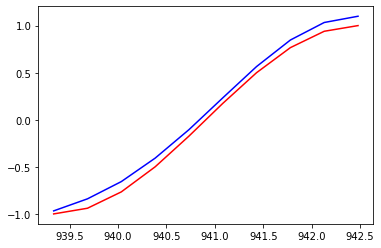

In [7]:
rnn.train()
plt.figure(2)
for step in range(EPOCHS):
    start, end = step * np.pi, (step+1)*np.pi # 一个时间周期
    steps = np.linspace(start, end, TIME_STEP, dtype=np.float32)
    x_np = np.sin(steps) 
    y_np = np.cos(steps)
    x = torch.from_numpy(x_np[np.newaxis, :, np.newaxis]) # shape (batch, time_step, input_size)
    y = torch.from_numpy(y_np[np.newaxis, :, np.newaxis])
    x=x.to(DEVICE)
    prediction, h_state = rnn(x, h_state) # rnn output
    # 这一步非常重要
    h_state = h_state.data # 重置隐藏层的状态, 切断和前一次迭代的链接
    loss = criterion(prediction.cpu(), y) 
    # 这三行写在一起就可以
    optimizer.zero_grad() 
    loss.backward() 
    optimizer.step() 
    if (step+1)%20==0: #每训练20个批次可视化一下效果，并打印一下loss
        print("EPOCHS: {},Loss:{:4f}".format(step,loss))
        plt.plot(steps, y_np.flatten(), 'r-')
        plt.plot(steps, prediction.cpu().data.numpy().flatten(), 'b-')
        plt.draw()
        plt.pause(0.01)


蓝色是模型预测的结果，红色是函数的结果，通过300次的训练，已经基本拟合了